**POINTAL Brice  
HERCOUËT Paul  
ROQUINARC'H Hoël**  

**Projet IAS 2021-2022**  

# Introduction  

## League of Legends
League of Legend est un jeu compétitif d'arène multijoueur en ligne, dans lequel 2 équipes (bleue et rouge) de 5 joueurs s'affrontent afin de détruire le nexus adverse.  
Chaque joueur contrôle un personnage appelé "champion" possédant des caractéristiques et des compétences qui lui sont propres.  
Au fil de la partie les joueurs vont récolter de l'**or** et de l'**expérience** en tuant des **sbires**, des unités qui apparaissent toutes les 30 secondes. Grâce aux statistiques gagnées en achetant des objets et en montant de niveau, les joueurs ont de meilleures chances de gagner lors des affrontement, ce qui leur permet de détruire les **tourelles** bloquant l'accès au nexus adverse. Tuer un adversaire est temporaire, mais rapporte aussi de l'or.  
A terme des **monstres élites** apparaissent sur la carte, permettant à l'équipe qui les vaincs de gagner des bonus.

## Problématique
Étant un jeu compétitif, il est important de mettre toutes les chances de son côté pour remporter les parties, sans perdre de temps. Cependant le jeu est très complexe et de nombreux éléments peuvent impacter la victoire. Nous allons dans cette étude nous intéresser à 2 choses :
* Faire re-sortir les éléments les plus corrélés avec la victoire d'une équipe afin de capitaliser sur ces derniers
* Déterminer rapidement quand une partie vaut ou non la peine d'être jouée, une partie perdue d'avance pouvant être abandonnée pour gagner du temps  

En conséquence, nous allons essayer de déterminer si il est effectivement possible de prédire efficacement l'issue d'une partie.

## Jeu de données
Notre jeu de données contient les statistiques de la dixième minute de 10 000 parties jouées en partie classée au rang diamant+. Chacune des 10 000 entrées contient des informations sur les 2 équipes telles que l'or, les tourelles prises, le nombre de champion tué ou encore le nombre de monstres élites tués... Ce jeu de données compte 40 features au total.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as skl
import math as mt
import seaborn as sn
import matplotlib.pyplot as plt

from scipy import stats
from collections import Counter

In [2]:
currentFile = open("high_diamond_ranked_10min.csv") ##import du dataset
dfInitial = pd.read_csv(currentFile)
#dfInitial
len(dfInitial.columns) #taille (nombre de features) d'origine

40

# Preprocessing

## Sélection de features

### Suppression des colonnes redondantes
De nombreuses features sont redondantes entre elles, nous allons donc les supprimer afin de simplifier notre dataset sans pour autant perdre de l'information.

**Les informations équivalentes sont les suivantes:**  
* Le nombre total de sbires tués et le nombre moyen de sbires tués par chaque équipe.  
* Le total d’or de chaque équipe, et la quantité d’or par minute (de même pour l'expérience).  
* Le nombre total de monstres élite tués est en fait la somme des **dragons** et **hérauts de la faille** tués.  
* Les différences d’or et d’expérience de l'équipe bleu, et celles de l'équipe rouges, peuvent être obtenues grâce au total d'or et d'expérience des 2 équipes  
* Le nombre total de sbires tués et le nombre de sbires tués par minutes par chaque équipe.  
* Les morts de chaque équipe sont intimement liés aux kills de l’équipe adverse, bien que la correspondance ne soit pas parfaite dans certaines parties.  
* Le booléen “first-blood”, indiquant si l'équipe est la première a avoir fait un kill, est présent pour les 2 équipes.  

**Autre:**  
* Le gameID permet d'identifier la partie, ce qui n’est pas utile à notre analyse  

Lorsque chaque équipe possède une feature réprésentant la même information, on privilégiera celle de l'équipe bleue (ex. pour la différence d'or on supprimera redGoldDiff)

In [3]:
toDrop = ["gameId", "redAvgLevel", "blueAvgLevel", "redTotalExperience", "blueTotalExperience",
          "redTotalGold", "blueTotalGold", "redGoldPerMin", "blueGoldPerMin", "redCSPerMin","blueCSPerMin",
          "redExperienceDiff", "redGoldDiff", "redFirstBlood", "redEliteMonsters", "blueEliteMonsters"]
dfSimplified = dfInitial.drop(toDrop, axis = 1)
#dfSimplified
len(dfSimplified.columns)

24

### Colonnes redDeaths et redKills
Les morts et les éliminiations d'une équipe sont fortement liées aux éliminations et aux morts de l'autre équipe, mais il est possible que la mort d'un joueur ne compte pas comme une élimination pour l'équipe adverse, on parle alors d'**exécution**. Nous allons nous intéresser au nombre de parties où ces données diffèrent afin de déterminer s'il est pertinent de supprimer ces features, ou si cela nous ferait perdre trop d'information

In [4]:
dfExecute = dfSimplified[(dfSimplified["redDeaths"] != dfSimplified["blueKills"]) | (dfSimplified["redKills"] != dfSimplified["blueDeaths"])]
len(dfExecute)

0

On remarque que notre dataset ne contient pas de parties dans laquelle un joueur a été exécuté, nous pouvons donc supprimer ces features sans perdre de l'information

In [5]:
dfSimplified = dfSimplified.drop(["redDeaths", "redKills"], axis = 1)
#dfSimplified
len(dfSimplified.columns)

22

### Monstres élites
On sait qu'il ne peut y avoir qu'un seul héraut de la faille, et un seul dragon dans les 10 premières minutes, on peut donc fusionner les 2 colonnes blueHeralds et redHeralds (resp. blueDragons et redDragons) on aurait alors 3 valeurs possible : 1, 0 et -1 correspondant respectivement à blue, red et none

In [6]:
colEliteMonsters = dfSimplified[["blueHeralds", "redHeralds", "redDragons", "blueDragons"]]
colEliteMonsters.loc[:, ['herald', 'dragon']] = -1
def convertEliteStats(dataframe):
    for index, current in dataframe.iterrows():
        if current['blueHeralds'] == 1:
            current['herald'] = 1
        elif current['redHeralds'] == 1:
            current['herald'] = 0
        if current['blueDragons'] == 1:
            current['dragon'] = 1
        elif current['redDragons'] == 1:
            current['dragon'] = 0
    return dataframe[["herald", "dragon"]]

dfSimplified = dfSimplified.drop(["redHeralds", "blueHeralds", "redDragons", "blueDragons"], axis = 1);
dfSimplified[["herald", "dragon"]] = convertEliteStats(colEliteMonsters)
#dfSimplified
len(dfSimplified.columns)

<ipython-input-6-cd6581752390>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colEliteMonsters.loc[:, ['herald', 'dragon']] = -1


20

# Dédoubler les données

## Problématique
Doubler nos données permettrait d'augmenter virtuellement la taille de notre dataset, et donc d'avoir un modèle mieux entraîné et globalement plus fiable.  
Le jeu est fait de sorte que chaque équipe ai les même chances de gagner, cependant un aspect important du jeu n'est pas symétrique : les monstres élites.
Les monstres élites (dragons et hérauts de la faille) offrent de nombreux avantages aux joueurs (or, expérience, statistiques, prise de tour), mais dû à la forme de la carte, chaque équipe est théoriquement avantagée sur la prise d'un type de monstre élites.

![L'image Lol_Map.png n'a pas pu être chargé](images/LoL_Map.png)  

## Principe
Nous allons donc comparer la prévalence des différents monstres élites dans les parties gagnées, ainsi que la proportion de parties où les différents objectifs ont été pris par chaque équipe. Si les monstres élites influent peu sur le taux de victoire, ou si chaque équipe a en réalité le même nombre de monstre élite en moyenne, alors nous pourrons considérer doubler les données.

In [7]:
def EliteMonsterRepartition(dataframe, in_col):
    cols = dataframe[dataframe[in_col] > -1]
    blue = 0
    red = 0
    amount = []

    for index, current in cols.iterrows():
        if current[in_col] == 1:
            blue += 1
        elif current[in_col] == 0:
            red += 1
        amount.append(1)

    #g = sn.barplot(x=in_col,y=amount,data=cols)
    #g.set(xticklabels=["Red team", "Blue team"])
    plt.figure(figsize=(6,5), dpi=80)
    plt.xlabel("Équipes", size=14)
    plt.xticks(size=11)
    plt.ylabel("Nombre de parties", size=14)
    plt.bar(['Red team', 'Blue team'], height = [red, blue], color = ['red', 'blue'])
    plt.title("Répartition du " + in_col + " par équipe", size = 16)
    plt.savefig("images/" + in_col + '.png', bbox_inches='tight')

    plt.show()
    print(in_col, 'bleus :', blue)
    print(in_col, 'rouges :', red)
    print('Un ' + in_col + ' est fait par l\'équipe bleue dans ' + str(round(100*blue/len(dataframe), 1)) + '% des parties')
    print('Un '+ in_col + ' est fait par l\'équipe rouge dans ' + str(round(100*red/len(dataframe), 1)) + '% des parties')

### Hérauts de la faille

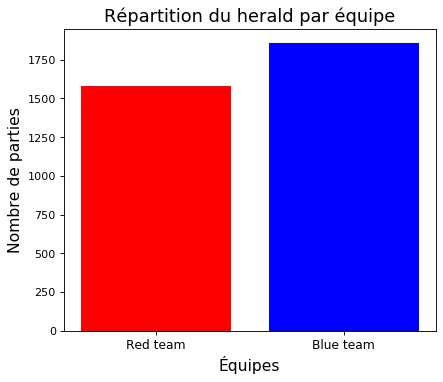

herald bleus : 1857
herald rouges : 1581
Un herald est fait par l'équipe bleue dans 18.8% des parties
Un herald est fait par l'équipe rouge dans 16.0% des parties


In [8]:
EliteMonsterRepartition(dfSimplified, 'herald')

On voit effectivement que l'équipe bleu est avantagée sur la prise des hérauts, la probabilité que l'équipe bleue fasse le héraut est plus élevée de presque 3%. 

### Dragons

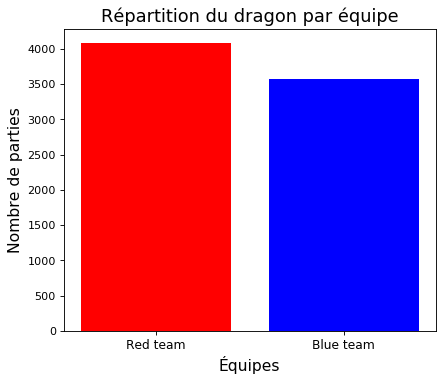

dragon bleus : 3576
dragon rouges : 4081
Un dragon est fait par l'équipe bleue dans 36.2% des parties
Un dragon est fait par l'équipe rouge dans 41.3% des parties


In [9]:
EliteMonsterRepartition(dfSimplified, 'dragon')

On voit effectivement que l'équipe rouge est avantagée sur la prise des dragons, la probabilité que l'équipe rouge fasse le dragon est plus élevée de 5%. 

## Analyse

On a vérifié que les équipes avaient bien un avantage sur l'accès à un type d'objectif, on s'intéresse maintenant à l'impact que chaque objectif a sur la victoire

In [10]:
def WinRepartition(df):
    cols = df[["blueWins", "herald", "dragon"]]
    dragon = 0
    herald = 0
    dragonG = 0
    heraldG = 0
    amountDragon = 0
    amountHerald = 0
    #amount = []
    
    for index, current in cols.iterrows():
        if current["blueWins"] == current["dragon"]:
            dragonG += 1
        if current["blueWins"] == current["herald"]:
            heraldG += 1
        if current["dragon"] > -1:
            dragon += 1
        if current["herald"] > -1:
            herald += 1
        #amount.append(1)
    
    plt.figure(figsize=(6,5),dpi=80)
    plt.xlabel("Monstres élites", size=14)
    plt.xticks(size=11)
    plt.ylabel("Nombre de parties", size=14)
    plt.yticks(np.arange(0, len(df), 500))
    plt.bar(['Dragon', 'Héraut'], height = [dragonG, heraldG], color = ['orange', 'purple'])
    plt.title("Nombre de monstres élites pris par l'équipe gagnante", size = 16)
    plt.savefig('images/Elite_Monsters_Repartition.png', bbox_inches='tight')

    plt.show()
    print(dragonG, "(" + str(round(100*dragonG/dragon, 1)) + "%)" + ' des dragons ont été pris par l\'équipe gagnante')
    print(heraldG, "(" + str(round(100*heraldG/herald, 1)) + "%)" + ' des hérauts ont été pris par l\'équipe gagnante')
    print('Sur un total de ' + str(len(df)) + ' parties')

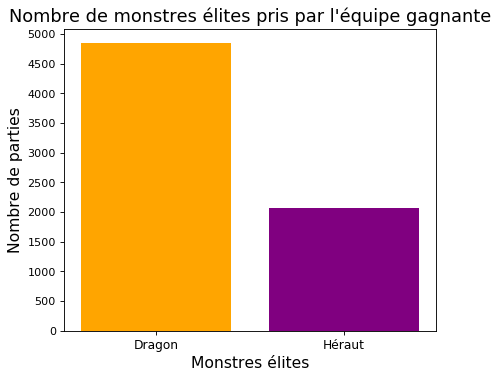

4846 (63.3%) des dragons ont été pris par l'équipe gagnante
2073 (60.3%) des hérauts ont été pris par l'équipe gagnante
Sur un total de 9879 parties


In [11]:
WinRepartition(dfSimplified)

## Bilan
Les dragons sont plus faciles à prendre pour l'équipe rouge et ont une meilleure corrélation avec la victoire que les hérauts.  
Bien que l'avantage ne soit que de quelques pourcents, il est trop important pour qu'on puisse doubler de manière fiable les données.

# Chances de victoires
Nous venons de nous intéresser aux chances de victoires de l'équipe obtenant un monstre élite dans les 10 premières minutes, et avons déterminé que celles-ci sont sensiblement plus élevées.  
Nous allons maintenant visualiser comment d'autres statistiques du début de partie sont liées à l'issue de celle-ci.

## Double objectif
On s'intéresse dans cette section aux parties dans lesquelles les 2 monstres élites ont été pris par la même équipe.

In [12]:
dfDouble = dfSimplified[["blueWins", "herald", "dragon"]]
dfDouble = dfDouble[(dfDouble["herald"] > -1) & (dfDouble["dragon"] > -1)]
dfDouble = dfDouble[dfDouble["herald"] == dfDouble["dragon"]]

In [13]:
#taux de victoire de l'équipe ayant les 2 objectifs dans la même partie
def DoubleWinRepartition(df):
    blueDoubleWin = 0
    redDoubleWin = 0
    win = 0
    blueTotal = 0
    redTotal = 0
    
    for index, current in df.iterrows(): #len(df) iterations
        if current["blueWins"] == current["herald"]: #si le gagnant == double
            win += 1
            if current["blueWins"] == 1: #si c'est les bleus qui ont gagné
                blueDoubleWin += 1
                blueTotal += 1
            else: #si c'est les rouges
                redDoubleWin += 1
                redTotal += 1
        else: #si le perdant == double
            if current["blueWins"] == 1: #le perdant est rouge 
                redTotal += 1
            else: #le perdant est bleu
                blueTotal += 1
    
    plt.figure(figsize=(6,5), dpi=80)
    plt.xlabel("Équipes", size = 14)
    plt.xticks(size=11)
    plt.ylabel("Nombre de parties", size = 14)
    plt.bar(["Blue team", "Red team", "Total de parties"], height = [blueTotal, redTotal, len(df)], color=["blue", "red", "green"])
    plt.title("Nombre de parties lors de laquelle une équipe a obtenu 2 monstres élites", size = 16)
    plt.savefig('images/Double_Elite_Amount.png', bbox_inches='tight')
    
    plt.show()
    
    print("Les 2 monstres élites ont été fait par la même équipe dans", len(df), "parties", "(" + str(round(100*len(df)/len(dfSimplified), 1)) + "%)")
    print("Parmi ces parties,", blueTotal, "(" + str(round(100*blueTotal/len(df), 1)) +"%)", "ont été fait par l'équipe bleue", "et", redTotal, "(" + str(round(100*redTotal/len(df), 1)) +"%)", "ont été fait par l'équipe rouge")
    
    plt.figure(figsize=(6,5), dpi=80)
    plt.xticks(size=11)
    plt.xlabel("Équipes", size=14)
    plt.ylabel("Nombre de parties", size=14)
    plt.yticks(np.arange(0, len(df), 100))
    plt.bar(['Blue team', 'Red team', 'Total de victoire'], height = [blueDoubleWin, redDoubleWin, win], color = ['blue', 'red', 'green'])
    plt.title("Nombre de victoires par une équipe ayant obtenu les 2 monstres élites", size = 16)
    plt.savefig('images/Double_Elite_Winrate.png', bbox_inches='tight')

    plt.show()
    print("Parmi les parties où les 2 monstres élites ont été fait par la même équipe,", win, "("+ str(round(100*win/len(df))) +"%)" , "ont mené à une victoire")
    print("Parmi ces parties, l'équipe bleue a gagné", blueDoubleWin, "(" +str(round(100*blueDoubleWin/blueTotal, 1))+"%)", "fois,", "et l'équipe rouge", redDoubleWin, "("+ str(round(100*redDoubleWin/redTotal, 1)) +"%)", "fois")
    

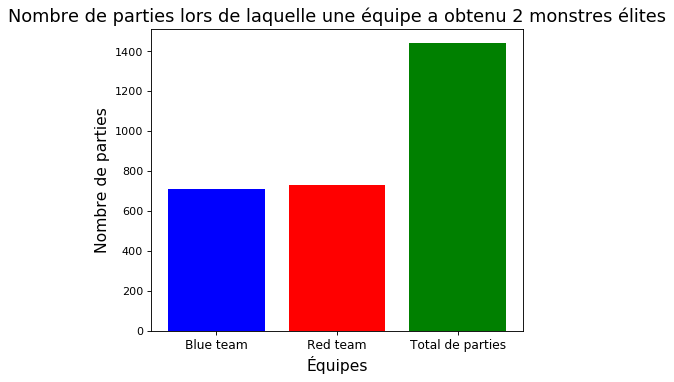

Les 2 monstres élites ont été fait par la même équipe dans 1440 parties (14.6%)
Parmi ces parties, 710 (49.3%) ont été fait par l'équipe bleue et 730 (50.7%) ont été fait par l'équipe rouge


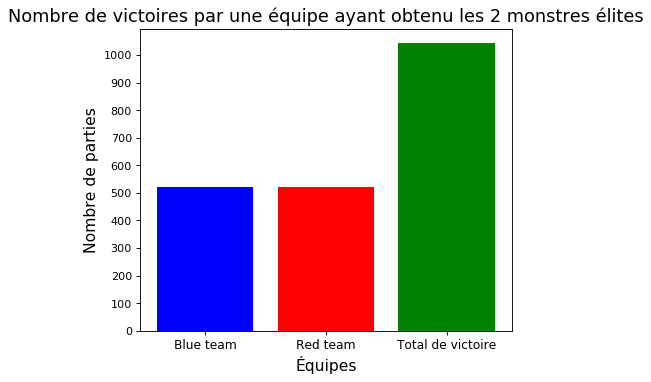

Parmi les parties où les 2 monstres élites ont été fait par la même équipe, 1043 (72%) ont mené à une victoire
Parmi ces parties, l'équipe bleue a gagné 522 (73.5%) fois, et l'équipe rouge 521 (71.4%) fois


In [14]:
DoubleWinRepartition(dfDouble)

On voit que les 2 équipes obtiennent un double-objectif en proportion égale, avec un léger avantage pour l'équipe rouge. Cela peut s'expliquer par le fait que cette équipe possède un avantage sur la prise du dragon, qui est un objectif bien plus contesté que le héraut de la faille.  
Une équipe qui parvient à sécuriser ces 2 objectifs dès le début de la partie a 7 chances sur 10 d'être la future équipe gagnante. Cela fait sens, puisque réussir à obtenir les deux monstres élites en 10 minutes donne un net avantage pour la suite de la partie, mais témoigne aussi d'une avance par rapport à l'équipe adverse, que ce soit en terme de statistiques pures, en terme de coordination d'équipe, ou même de contrôle de la carte. C'est donc un excellent indicateur des chances de victoire d'une équipe.

## Tourelles
Les tourelles empêchent l'équipe adverse d'avancer librement sur la carte, les détruire permet donc de prendre le contrôle et rapporte une quantité conséquente d'or à toute l'équipe. Cependant, une croyance veut que prendre rapidement une tourelle soit désavantageux. En effet, cela permet à l'adversaire de tuer les sbires tout en étant plus proche de sa base, et donc plus en sécurité, là où le joueur ayant pris la tour devra en moyenne plus s'avancer pour tuer des sbires, et donc se mettre en danger.
On s'intéresse dans cette section au nombre de tours prises par les équipes, ainsi qu'au nombre de tour prise par l'équipe gagnante.

In [15]:
#taux de victoire en fonction du nombre de tourelles prises
def WinrateByTowers(df):
    towersDestroyed = []
    win = []
    
    for index, current in df.iterrows():
        towersDestroyed.append(current["blueTowersDestroyed"])
        towersDestroyed.append(current["redTowersDestroyed"])
        if current["blueWins"] == 1:
            win.append(current["blueTowersDestroyed"])
        else:
            win.append(current["redTowersDestroyed"])
        
    plt.figure(figsize=(8,6), dpi=80)
    plt.hist(towersDestroyed,bins = 5)
    plt.hist(win, bins = 5)
    plt.title("Nombre de tours détruites par une équipe, et nombre de tours détruites par l'équipe gagnante", fontsize=16)
    plt.xlabel("Nombre de tours détuites", fontsize=16)
    plt.xticks(np.arange(0.5, 4.2, 0.75), [0, 1, 2, 3, 4], fontsize=12)
    plt.yticks(np.arange(0, 20000, 1000), fontsize=12)
    plt.ylabel("Nombre de parties", fontsize=16)
    #plt.yscale("symlog", linthreshy = 1000)
    plt.legend(["Nombre de tours détruites par une équipe", "Nombre de tours détruites par une équipe victorieuse"])
    plt.savefig('images/Towers_Destroyed.png', bbox_inches='tight')
    
    plt.show()

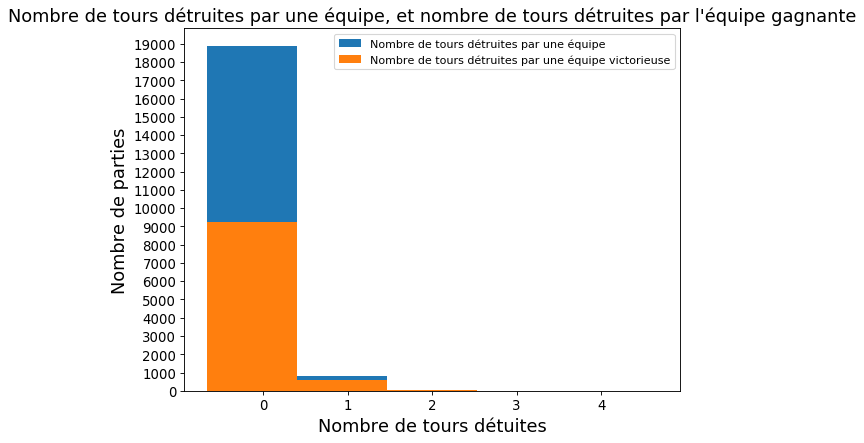

In [16]:
WinrateByTowers(dfSimplified)

On remarque qu'il est peu fréquent qu'une des 2 équipes détruise une tour dans les 10 premières minutes, mais le cas échéant cela est très révélateur de l'équipe qui gagnera la partie. Cela est d'autant plus valide pour 3 tours ou plus, puisque pour que cela arrive il faut généralement que l'équipe adverse abandonne ou se laisse faire.  
Il re-sort tout de même que prendre une tourelle très tôt donne un avantage en or et en contrôle de la carte suffisant pour assurer la victoire, ce qui contredit la croyance décrite plus haut.

## Premier-sang
Le "premier-sang" est la première élimination de la partie, elle donne un léger bonus d'or et permet à un joueur de prendre l'avantage dès le début de la partie, à condition de jouer de manière suffisament agressive, et donc de risquer d'être puni. On s'attend naturellement à ce que l'équipe obtenant le premier-sang ai plus de chance de victoires, mais à quel point ?

In [17]:
#taux de victoire de l'équipe ayant le premier sang
def firstBloodRepartition(df):
    bluefb = 0
    redfb = 0
    win = 0
    
    for index, current in df.iterrows():
        
        if current["blueWins"] == current["blueFirstBlood"]:
            win += 1
        if current["blueFirstBlood"] == 1:
            bluefb += 1
        else:
            redfb += 1
    
    plt.figure(figsize=(6,5), dpi=80)
    plt.xlabel("Équipes", size=14)
    plt.xticks(size=11)
    plt.ylabel("Nombre de parties", size=14)
    plt.yticks(np.arange(0, len(df), 500))
    plt.bar(['Blue team', 'Red team', 'Total de victoire'], height = [bluefb, redfb, win], color = ['blue', 'red', 'green'])
    plt.title("Nombre de premier-sang par équipe et total de premier-sang victorieux", size = 16)
    plt.savefig('images/First_Blood.png', bbox_inches='tight')
    
    plt.show()
    
    print("L'équipe obtenant le premier sang est victorieuse dans " + str(round(100*win/len(df), 1)) + "% des parties")
    print("L'équipe bleue obtient le premier-sang dans " + str(round(100*bluefb/len(df), 1)) + "% des parties")
    print("L'équipe rouge obtient le premier-sang dans " + str(round(100*redfb/len(df), 1)) + "% des parties")

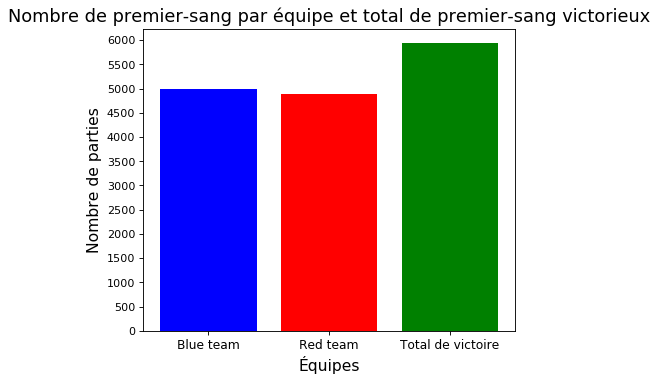

L'équipe obtenant le premier sang est victorieuse dans 60.1% des parties
L'équipe bleue obtient le premier-sang dans 50.5% des parties
L'équipe rouge obtient le premier-sang dans 49.5% des parties


In [18]:
firstBloodRepartition(dfSimplified)

On remarque que l'équipe bleue a légèrement plus tendance à obtenir le premier-sang. Cela peut s'expliquer grâce aux "invasions" de la jungle qui prennent place en début de partie. En effet il arrive souvent qu'une des 2 équipes, voire les 2, décide d'aller à la rencontre de l'équipe adverse pour l'affronter afin de prendre l'avantage le plus tôt possible. La carte étant symétrique par rotation, et les invasions prenant la plupart du temps place sur le bas de la carte, il est possible que le terrain donne l'avantage à l'équipe bleue.  
Concernant le taux de victoire, on peut confirmer qu'obtenir le premier-sang est lié à de meilleures chances de gagner. Tout comme pour les doubles-objectifs, obtenir le premier sang témoigne généralement de meilleures compétences ainsi que de meilleures connaissance du jeu de la part d'un joueur, cette avance est encore plus accentuée par l'or gagnée lors de cette élimination.

## Écart d'or

In [19]:
def goldRepartition(df):
    gold = df["blueGoldDiff"]
    exp = df["blueExperienceDiff"]
    winner = df["blueWins"].copy()
    winner.loc[winner == 1] = "blue"
    winner.loc[winner ==0] = "red"
    
    plt.figure(figsize=(6,7), dpi=80)
    plt.scatter(gold, exp, c = winner)
    plt.xlabel("Or", size=14)
    plt.xticks(np.arange(-10000, 12000, 3000),size=11)
    plt.ylabel("Expérience", size=14)
    plt.yticks(np.arange(-10000, 10000, 1500))
    slope, intercept, r_value, p_value, std_err = stats.linregress(gold, exp)
    fitLine = slope * gold + intercept
    #halfline = -slope * gold + intercept
    plt.plot(gold, fitLine, c='green', linewidth = 4)
    #plt.plot(gold, halfline, c = 'gray', linewidth =4)
    plt.title("Vainqueur selon la différence d'or et d'expérience entre les équipes")
    plt.savefig('images/Winner_by_Gold_Exp.png', bbox_inches='tight')
    
    plt.show()
    
    print("On détermine que la pente liant l'or et l'expérience d'une équipe est d'équation : exp =", str(round(slope, 1)) +"*gold" + str(round(intercept, 1)))

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


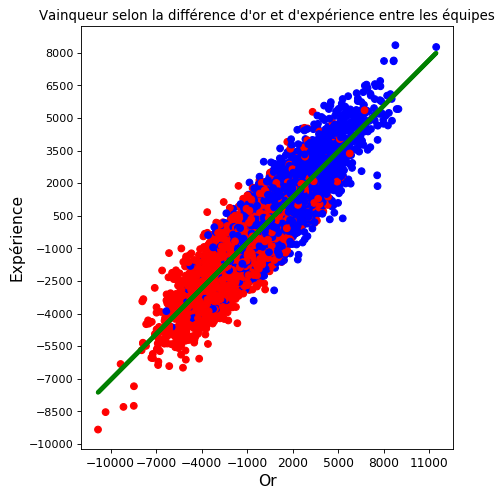

On détermine que la pente liant l'or et l'expérience d'une équipe est d'équation : exp = 0.7*gold-43.7


In [20]:
goldRepartition(dfSimplified)

Ces deux caractéristiques sont les plus importantes pour déterminer la force d'une équipe et semblent corrélées, il n'y a que 2 aspects du jeu qui impactent à la fois l'or et l'expérience de manière significative:
* Les sbires qui offrent un peu d'or et d'expérience (et par extension les morts qui font louper des sbires)  
* Les éliminations qui offrent beaucoup d'or et un peu d'expérience   

On remarque qu'une différence d'or et d'expérience trop importante garanti la victoire d'une équipe, il faut donc logiquement capitaliser sur les sbires et les éliminations dès le début de partie. Une avance en or de seulement 1200 pièces d'or, c'est dire 4 éliminations, sans compter les sbires perdus, suffit à faire fortement pencher la balance du côté d'une des équipes.

## Prise de vision
On s'intéresse dans cette section à la prise de vision, c'est à dire aux balises placées. Les balises permettent de révéler une zone de la carte dans laquelle aucun allié n'est présent. Il en existe de plusieurs types, mais la plupart ne sont pas disponible dans la période temporelle qui nous concerne.  
Le délai de récupération des balises étant d'environ 200 secondes, en comptant les balises que l'on peut acheter dans la boutique, on peut estimer le nombre maximum de balises placées par une équipe à 60 et ainsi éliminer les parties dans lesquelles un joueur a profité d'un objet pour placer plusieurs dizaines de balises dans sa base. Cela n'a pas d'intérêt, et ne coûte rien au joueur, c'est pourquoi on ne supprime pas ces entrées du dataset.

In [21]:
dfVision = dfSimplified.copy()
dfVision = dfVision[["blueWins", "blueWardsPlaced", "redWardsPlaced"]]
dfVision = dfVision[(dfVision["blueWardsPlaced"] <= 60) & (dfVision["redWardsPlaced"] <= 60)]
#dfVision

In [22]:
def GameByVision(df):
    plt.figure(figsize=(6,5), dpi=80)
    plt.xlabel("Nombre de balises", size=14)
    plt.ylabel("Nombre de parties", size=14)
    plt.hist([df["blueWardsPlaced"], df["redWardsPlaced"]],bins = 'auto', stacked=True, color = ['red', 'blue'])
    plt.title("Nombre de balises placées par équipe", size = 16)
    
    plt.show()

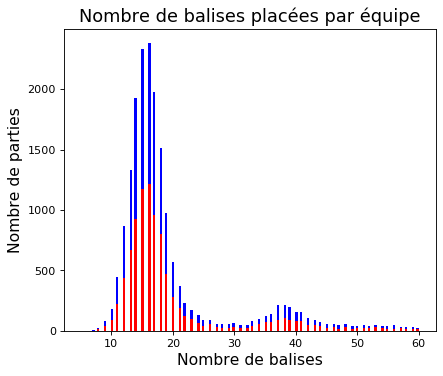

In [23]:
GameByVision(dfVision)

On observe un pic autour de 15, ce qui représente 3 balises posées par joueurs. Il faut donc idéalement se situer légèrement au dessus pour avoir plus de vision que la moyenne des joueurs. Celà peut s'accomplir simplement en posant les balises dès qu'elles sont disponibles ou encore en en achetant dans la boutique.  

On s'intéresse maintenant aux balises placées par l'équipe gagnante, plus particulièrement à la différence de balises placées.

In [24]:
def WinByVision(df):
    win = []
    lose = []
    
    for index, current in df.iterrows():
        if current["blueWins"] == 1:
            win.append(current["blueWardsPlaced"])
            lose.append(current["redWardsPlaced"])
        else:
            win.append(current["redWardsPlaced"])
            lose.append(current["blueWardsPlaced"])
    plt.figure(figsize=(6,5), dpi=80)
    plt.xlabel("Balise d'avance", size=14)
    plt.ylabel("Nombre de parties", size=14)
    plt.hist(np.subtract(win, lose),bins = 55, stacked=True, color = ['black'])
    plt.title("Nombre de balises d'avance de l'équipe gagnante", size=16)
    plt.show()

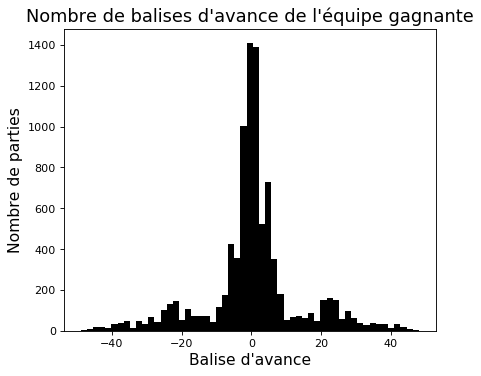

In [25]:
WinByVision(dfVision)

On voit que le graphe est sensiblement symétrique, centré en 0. Cela signifie qu'avoir l'avantage de la vision en début de partie n'influe pas sur les chances de victoires, quand bien même cela permet d'empêcher des morts autrement prévisibles, ou de sécuriser des monstres élites.

# Conclusion

Nous avons déterminé plusieurs éléments influant de manière significative sur les chances de victoire dès le début de la partie.  
Un joueur ou une équipe peut donc mettre en place plusieurs stratégies pour obtenir une victoire rapide.
Elle peut tout d'abord se concentrer sur les monstres élites, les bonus donnés par les dragons peuvent sembler anecdotique, ils jouent tout de même un rôle important dans l'issue de la partie. De même le héraut de la faille est difficile à faire, et peut sembler ne pas en valoir la peine, mais sa capacité à garantir la destruction d'une tour est un atout majeur. En effet, nous avons pu voir que prendre une tour très tôt dans la partie est un avantage conséquent.  
De manière générale sécuriser rapidement un objectif, que ce soit une tour ou un monstre élite, fait fortement grimper les chances de victoires d'une équipe. 
L'obtention des 2 premiers monstres élites mènent quant à elle à une victoire dans plus de 70% des parties. Il ne faut cependant pas négliger le côté de la carte sur lequel on joue, celui-ci affectant les opportunités de prendre l'un ou l'autre.
L'or étant, avec l'expérience, un élément fortement lié à la victoire  il est primordial d'en obtenir un maximum. En ce sens, essayer d'obtenir le premier sang, quitte à se mettre en danger, est un pari intéressant pour déterminer rapidement l'issue de la partie. Un joueur qui arrive à capitaliser sur son avance pour l'accentuer en tuant en boucle les adversaires rendra quasi-nulles les chances de victoire de l'équipe adverse. En effet nous avons constaté qu'un écart trop important en or et/ou en expérience garanti la victoire à l'équipe possèdant l'avantage de ces ressources, il est donc nécessaire d'être l'équipe en avance, ou au moins de ne pas tomber trop derrière. Pour cela il ne faut pas négliger ce qu'apporte les sbires, mais aussi la perte que représente une mort.  
Dans le cas où l'équipe adverse est devant sur plusieurs points mentionnés, il ne vaut sans doute pas la peine de jouer la partie jusqu'au bout, les chances de victoires pouvant facilement tomber en dessous de 30%.
Globalement, nous avons vu que les 10 premières minutes ont un impact conséquent sur la fin de la partie, et qu'il vaut donc mieux mettre en place une stratégie agressive dès le début. Cela peut être fait en choisissant un champion très fort au début de la partie, ou en sélectionnant des compétences bonus (runes) visant à appuyer la prise de tours ou d'éliminations.

**Ce qui suit a été ajouté APRÈS le rendu du projet**  
# Modélisation

In [166]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
df = dfSimplified
part = round(len(df)/10)
dfTrain, dfTest = train_test_split(df,test_size=part,random_state=1,stratify=df.blueWins)
X_train = dfTrain.iloc[:, 1:]
Y_train = dfTrain.iloc[:, 0]

X_test = dfTest.iloc[:, 1:]
Y_test = dfTest.iloc[:, 0]
print(dfTrain.shape)
print(dfTest.shape)
print(dfTrain.blueWins.value_counts(normalize=True)) #vérifie la bonne répartition des victoires
print(dfTest.blueWins.value_counts(normalize=True))

(8891, 20)
(988, 20)
0    0.500956
1    0.499044
Name: blueWins, dtype: float64
0    0.501012
1    0.498988
Name: blueWins, dtype: float64


## Arbre de décision

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [28]:
arbreFirst = DecisionTreeClassifier(min_samples_split=2,min_samples_leaf=181)
arbreFirst.fit(X = dfTrain.iloc[:, 1:], y = dfTrain.blueWins)

DecisionTreeClassifier(min_samples_leaf=181)

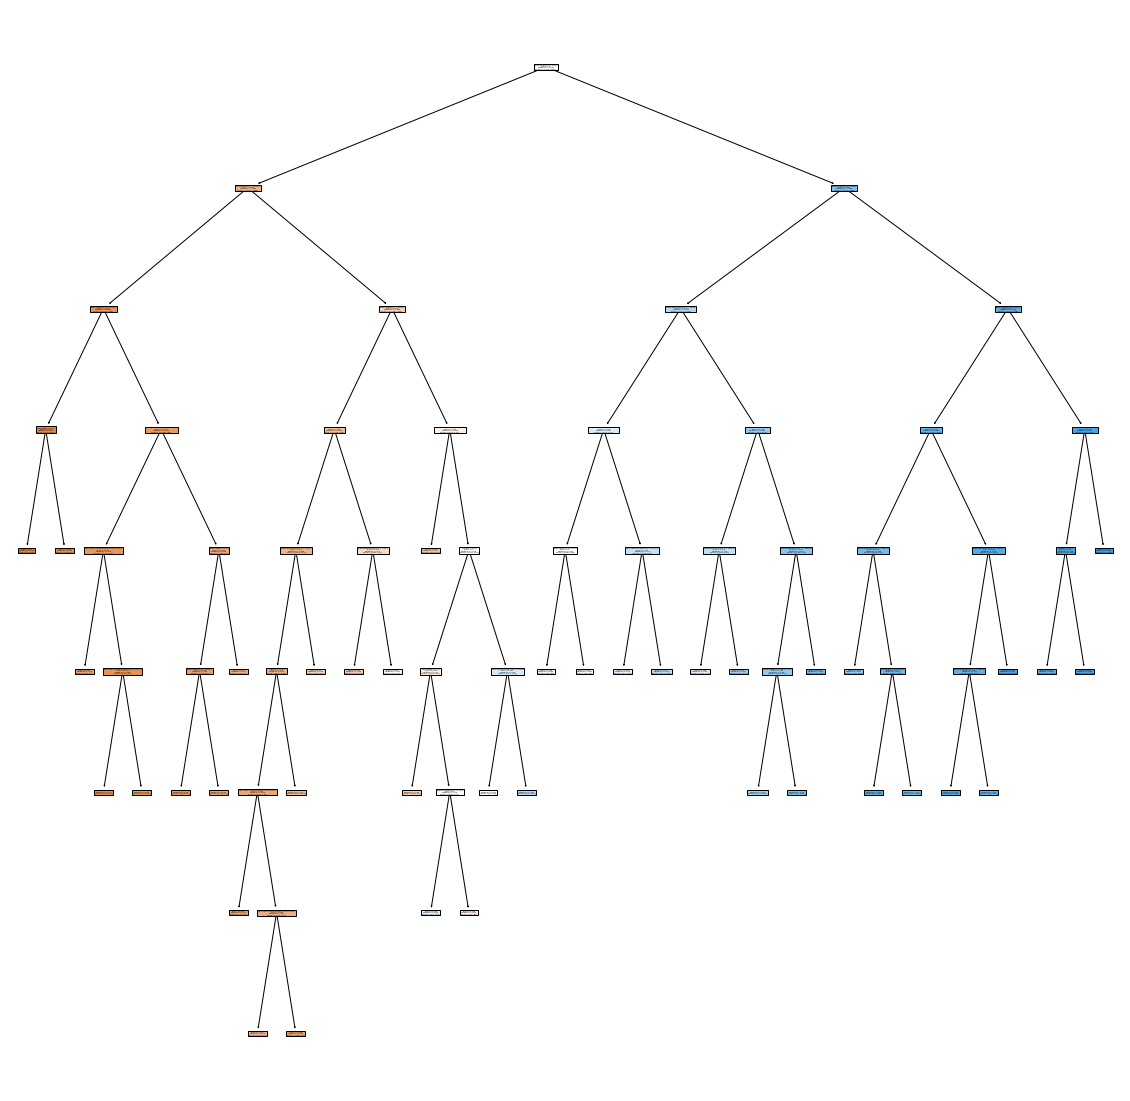

In [29]:
plt.figure(figsize=(20, 20))
plot_tree(arbreFirst,feature_names = list(df.columns[1:]),filled=True)
plt.savefig('images/Decision_Tree.png', bbox_inches='tight')

plt.show()

In [30]:
impVarFirst={"Variable":df.columns[1:],"Importance":arbreFirst.feature_importances_}
print(pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False))

                        Variable  Importance
9                   blueGoldDiff    0.926268
10            blueExperienceDiff    0.038755
18                        dragon    0.018440
16   redTotalJungleMinionsKilled    0.003611
13                    redAssists    0.003079
15         redTotalMinionsKilled    0.002769
5                    blueAssists    0.002766
3                      blueKills    0.002208
1             blueWardsDestroyed    0.001272
0                blueWardsPlaced    0.000833
4                     blueDeaths    0.000000
6            blueTowersDestroyed    0.000000
7         blueTotalMinionsKilled    0.000000
8   blueTotalJungleMinionsKilled    0.000000
2                 blueFirstBlood    0.000000
11                redWardsPlaced    0.000000
12             redWardsDestroyed    0.000000
14            redTowersDestroyed    0.000000
17                        herald    0.000000


**Meilleur résultat :**  
min_split = 2  
min_leaf = 181  
accuracy = 0.72165991902834

## Neural Network

In [31]:
from sklearn.neural_network import MLPClassifier

In [32]:
model = MLPClassifier(activation = 'logistic', solver = 'lbfgs')
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
metrics.accuracy_score(Y_test, Y_pred)

/home/brice/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.7054655870445344

**Meilleur résultat :**  
activation = logistic  
solver = lbfgs  
accuracy = 0.7155870445344129

## SVM

In [33]:
from sklearn.svm import SVC 

In [34]:
clf = SVC(kernel='rbf', random_state = 1)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
metrics.accuracy_score(Y_test, Y_pred)

0.7125506072874493

**Meilleur résultat :**  
kernel = rbf  
accuracy = 0.7125506072874493

## Régression logistique

In [35]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

In [36]:
logi = LogisticRegression(max_iter=92, random_state = 1)
logi.fit(X_train, Y_train)
Y_pred = logi.predict(X_test)
metrics.accuracy_score(Y_test, Y_pred)

0.7246963562753036

**Meilleur résultat :**  
max_iter = 92  
accuracy = 0.7246963562753036

In [38]:
dfAn = dfTest.copy()
dfAn["blueWinsPred"] = Y_pred #les valeurs prédites, sous forme de dataframe

In [85]:
def filterIncorrect(df):
    fauxPos = [] #les faux positifs (on a dit que blue gagnerait mais ce n'est pas le cas)
    fauxNeg = [] #les faux négatifs (on a dit que red gagnerait mais ce n'est pas le cas)
    incorrect = []
    correct = []
    
    for index, current in df.iterrows():
        if current["blueWins"] != current["blueWinsPred"]:
            if current["blueWins"] == 1:
                fauxNeg.append(current)
            else:
                fauxPos.append(current)
            incorrect.append(current)
        else:
            correct.append(current)
    return pd.DataFrame(correct), pd.DataFrame(fauxPos), pd.DataFrame(fauxNeg), pd.DataFrame(incorrect)

In [86]:
dfCorrect, dfFP, dfFN, dfIncorrect = filterIncorrect(dfAn)

In [87]:
def goldExpRepartition(df, title):
    gold = df["blueGoldDiff"]
    exp = df["blueExperienceDiff"]
    winner = df["blueWins"].copy()
    winner.loc[winner == 1] = "blue"
    winner.loc[winner ==0] = "red"
    
    plt.figure(figsize=(6,7), dpi=80)
    plt.scatter(gold, exp, c = winner)
    plt.xlabel("Or", size=14)
    plt.xticks(np.arange(-10000, 12000, 3000),size=11)
    plt.ylabel("Expérience", size=14)
    plt.yticks(np.arange(-10000, 10000, 1500))
    #slope, intercept, r_value, p_value, std_err = stats.linregress(gold, exp)
    splitLine = -0.929 * gold + 0
    #halfline = -slope * gold + intercept
    plt.plot(gold, splitLine, c='green', linewidth = 4)
    #plt.plot(gold, halfline, c = 'gray', linewidth =4)
    plt.title(title)
    plt.savefig('images/' + title + '.png', bbox_inches='tight')
    
    plt.show()

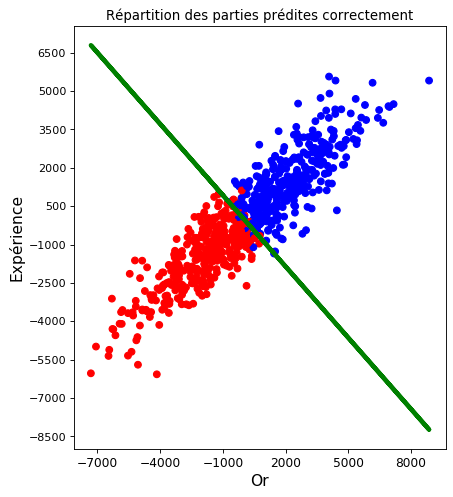

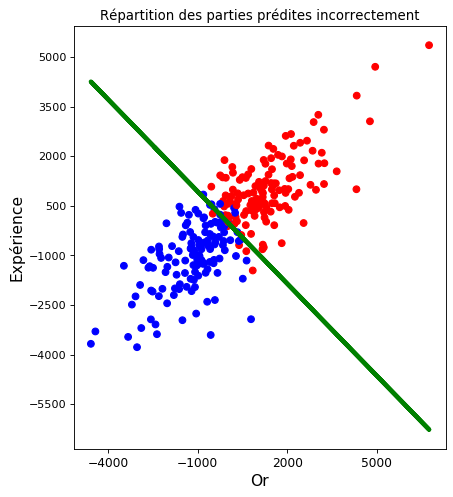

In [88]:
goldExpRepartition(dfCorrect, "Répartition des parties prédites correctement")
goldExpRepartition(dfIncorrect, "Répartition des parties prédites incorrectement")
#goldExpRepartition(dfFN, "Répartition des faux négatifs (faux rouge)")
#goldExpRepartition(dfFP, "Répartition des faux positifs (faux bleu)")
#rappel : abscisse = avantange en or de l'équipe bleue, ordonnées = avantage en or de l'équipe rouge, couleur = équipe gagnante

On voit bien que les parties que le modèle n'a pas réussi à prédire correctement, sont celles lors desquelles l'équipe possédant l'avantage en or et en expérience en début de partie n'est pas l'équipe gagnante

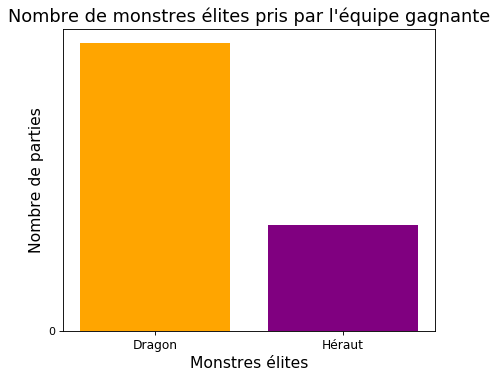

393 (70.9%) des dragons ont été pris par l'équipe gagnante
145 (66.2%) des hérauts ont été pris par l'équipe gagnante
Sur un total de 716 parties


In [90]:
WinRepartition(dfCorrect)

On voit que la proportion de monstre élite pris par l'équipe gagnante est au-dessus de la proportion réelle

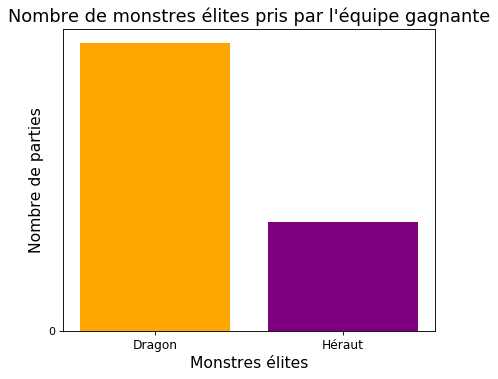

116 (56.6%) des dragons ont été pris par l'équipe gagnante
44 (44.9%) des hérauts ont été pris par l'équipe gagnante
Sur un total de 272 parties


In [91]:
WinRepartition(dfIncorrect)

On voit que la proportion de monstre élite pris par l'équipe gagnante est en-dessous de la proportion réelle

On peut en conclure qu'une part non négligeable (environ 10%) des parties ayant trompé le modèle sont celles lors desquelles l'équipe ayant pris un ou plusieurs monstres élite n'est pas l'équipe gagnante

## Et avec PCA ?

In [92]:
from sklearn.decomposition import PCA

In [188]:
X = df.iloc[:, 1:]
Y = df.iloc[:, 0]

In [245]:
pca = PCA(n_components=6)

In [246]:
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)
finalDf = pd.concat([Y, principalDf], axis = 1,)

In [247]:
dfTrain, dfTest = train_test_split(finalDf,test_size=2*part,random_state=1,stratify=finalDf.blueWins)
                 #train_test_split(df,test_size=part,random_state=1,stratify=df.blueWins)
dfTest, dfValid = train_test_split(dfTest, test_size=part, random_state=1, stratify=dfTest.blueWins)
X_train = dfTrain.iloc[:, 1:]
Y_train = dfTrain.iloc[:, 0]

X_test = dfTest.iloc[:, 1:]
Y_test = dfTest.iloc[:, 0]

X_valid = dfValid.iloc[:, 1:]
Y_valid = dfValid.iloc[:, 0]

print(dfTrain.shape)
print(dfTest.shape)
print(dfTrain.blueWins.value_counts(normalize=True)) #vérifie la bonne répartition des victoires
print(dfTest.blueWins.value_counts(normalize=True))

(7903, 7)
(988, 7)
0    0.500949
1    0.499051
Name: blueWins, dtype: float64
0    0.501012
1    0.498988
Name: blueWins, dtype: float64


In [248]:
logi = LogisticRegression(max_iter=92, random_state = 1)
logi.fit(X_train, Y_train)

LogisticRegression(max_iter=92, random_state=1)

In [249]:
Y_pred = logi.predict(X_test)
metrics.accuracy_score(Y_test, Y_pred)

0.7105263157894737

In [250]:
Y_pred = logi.predict(X_valid)
metrics.accuracy_score(Y_valid, Y_pred)

0.7257085020242915

## Réponse binaire